# Dark matter shards of $\omega$ centauri
Taking the the velocities of the objects reported in https://arxiv.org/abs/1804.07050 and creating a composite velocity distribution from them

In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 100
v = linspace(0,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
beta = HaloModel.SausageBeta
v_lab = LabVelocitySimple(67,HaloModel)

# Load shards
dat = loadtxt('../shards.txt',delimiter=',')

# Speed distributions
fv_Iso = SpeedDist_Isotropic(v,v_lab,v0,v_esc)

nshards = 21
xi_halo = 0.8
xi_s = (1.0-xi_halo)/(1.0*nshards)
fv = zeros(shape=(nshards,n))
print 'Shards velocities (vx,vy,vz) and dispersions (sig_x,sig_y,sig_z):'
for i in range(0,nshards):
    v_s = dat[i,0:3]
    sig_s = dat[i,6:9]
    fv[i,:] = SpeedDist_3D(v,(v_lab-v_s),sig_s)/(1.0*nshards)
    plt.fill_between(v,1e3*fv[i,:],linewidth=3,alpha=0.1)
    sigr = sig_s[0]
    sigphi = sig_s[1]
    sigz = sig_s[2]
    beta = 1.0-(sigr**2.0+sigz**2.0)/(2*sigr**2.0)
    print i+1,":    V_str = ",v_s,"|     sigma_str = ",sig_s



0 :    V_str =  [  -8.6 -286.7  -67.9] |     sigma_str =  [ 115.3   49.9   60. ]
1 :    V_str =  [  54.1 -393.8   68.3] |     sigma_str =  [ 147.2   45.7  149.4]
2 :    V_str =  [  47.8 -254.6   71.8] |     sigma_str =  [ 110.2   27.8  172.1]
3 :    V_str =  [  28.  -275.1   18. ] |     sigma_str =  [ 186.    62.7  136.5]
4 :    V_str =  [ 177.6 -287.9  117.9] |     sigma_str =  [ 114.6   46.   162.7]
5 :    V_str =  [-10.  -82.3  -0.6] |     sigma_str =  [  83.2   21.2  162.7]
6 :    V_str =  [ -11.9 -222.1   88. ] |     sigma_str =  [ 187.6   44.   134.9]
7 :    V_str =  [ -92.3 -160.2  -33.4] |     sigma_str =  [ 274.6   66.5  178.1]
8 :    V_str =  [ -11.2  159.6 -166.5] |     sigma_str =  [  65.6   21.9  151.7]
9 :    V_str =  [-242.4  109.9  180.7] |     sigma_str =  [ 229.2   35.9  236.1]
10 :    V_str =  [   8.2  192.   -25. ] |     sigma_str =  [ 124.    40.2  186.6]
11 :    V_str =  [  48.4  164.5 -171.1] |     sigma_str =  [ 139.6   24.2  172. ]
12 :    V_str =  [-115.6   17

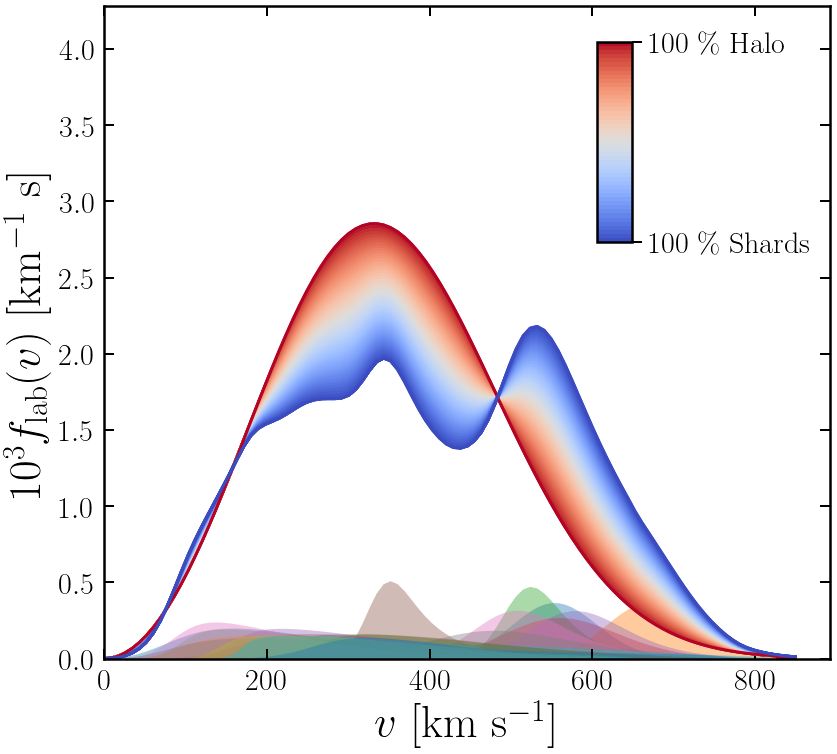

In [186]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fv'


n_xi = 50
xi_vals = linspace(0,1,n_xi)
col = flipud(cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
for i in range(0,n_xi):
    plt.fill_between(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv_Iso),y2=1e3*sum(fv,0),color=col[i,:],alpha=0.5)
    plt.plot(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv_Iso),'-',color=col[i,:],linewidth=3)
    
plt.plot(v,1e3*fv_Iso,'-',color=col[0,:],linewidth=3,label=r'100 \% Halo')
plt.plot(v,1e3*sum(fv,0),'-',color=col[-1,:],linewidth=3,label=r'100 \% Shards')

# Plot individual streams
for i in range(0,nshards):
    plt.fill_between(v,1e3*fv[i,:],linewidth=3,alpha=0.4)
    
# Plot fiddling
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv_Iso)*1.5)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]",fontsize=45);

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-50, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([r'100 \% Shards', r'100 \% Halo'])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Annual modulation
Plot range and amplitude of the annual modulation

In [98]:
# DM params
A = Xe131.MassNumber
m_chi = 20.0
sigma_p = 1.0e-45

# Energy range
n = 1000
E_th = 0.0001
E_max = 50.0
E = linspace(E_th,E_max,n)
v_min = MinimumWIMPSpeed(E,A,m_chi)


xi_halo = 0.0
xi_s = (1.0-xi_halo)/(1.0*nshards)

# Loop over times
ndays = 365
days = linspace(0,365,ndays)
dR0 = zeros(shape=(ndays,n))
dR = zeros(shape=(ndays,n))
R = zeros(shape=ndays)
R0 = zeros(shape=ndays)
for i in range(0,ndays):
    v_lab = LabVelocitySimple(days[i],HaloModel)
    gmin0 = gvmin_Isotropic(v_min,v_lab,v0,v_esc)
    gmin = xi_halo*gmin0
    for isub in range(0,nshards):
        v_spin = dat[isub,0:3]
        v0_str = sqrt(sum(dat[isub,6:9]**2.0))/(3.0*sqrt(2.0))
        gmin += xi_s*gvmin_Isotropic(v_min,v_lab-v_spin,v0_str,v_esc)
        
    dR[i,:] = diffRecoilRate_SI(E,gmin,A,sigma_p,m_chi,rho_0=0.55)
    dR0[i,:] = diffRecoilRate_SI(E,gmin0,A,sigma_p,m_chi,rho_0=0.55)
    R[i] = trapz(dR[i,(E>E_th)],E[E>E_th])
    R0[i] = trapz(dR0[i,(E>E_th)],E[E>E_th])

Rdiff = zeros(shape=n)
Rdiff0 = zeros(shape=n)
for i in range(0,n):
    Rdiff[i] = max(dR[:,i])-min(dR[:,i])
    Rdiff0[i] = max(dR0[:,i])-min(dR0[:,i])

LabFuncs.py:176: RuntimeWarning: invalid value encountered in divide
  F = (3*(sin(q*R_1) - q*R_1*cos(q*R_1))*exp(-q*q*s*s/2.0)/(q*R_1)**3)


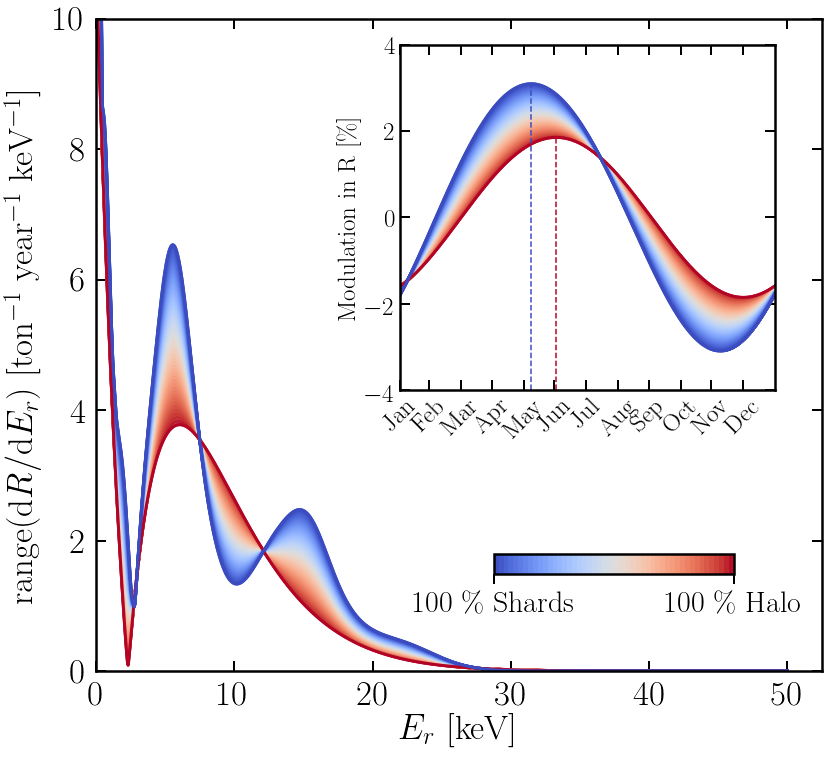

In [197]:
# Figure
pltname = 'Shards_annualmod'
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(111)
left, bottom, width, height = [0.45, 0.45, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

# Main plot
plt.sca(ax1)
for i in range(0,n_xi):
    plt.fill_between(E,xi_vals[i]*Rdiff+(1-xi_vals[i])*Rdiff0,y2=Rdiff,color=col[i,:],alpha=0.5)
    plt.plot(E,xi_vals[i]*Rdiff+(1-xi_vals[i])*Rdiff0,'-',color=col[i,:],linewidth=3)
plt.plot(E,Rdiff0,label='Halo',linewidth=3,color=col[0,:])
plt.plot(E,Rdiff,label='Subs.',linewidth=3,color=col[-1,:])
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"$E_r$ [keV]",fontsize=35);
plt.ylabel(r"range($\textrm{d}R/\textrm{d}E_r$) [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
ax1.set_xlim(left=0.0)
ax1.set_ylim(bottom=0.0,top=10.0)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)

# Inset plot
plt.sca(ax2)
R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
for i in range(0,n_xi):
    dR = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
    plt.fill_between(days,dR,y2=100*(R-Rmid)/Rmid,color=col[i,:],alpha=0.5)
    plt.plot(days,dR,'-',color=col[i,:],linewidth=3)
plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
plt.plot(days,100*(R-Rmid)/Rmid,linewidth=3,color=col[-1,:])
dR = 100*(R0-R0mid)/R0mid
plt.plot([days[argmax(dR)],days[argmax(dR)]],[-4.0,amax(dR)],'--',color=col[0,:])
dR = 100*(R-Rmid)/Rmid
plt.plot([days[argmax(dR)],days[argmax(dR)]],[-4.0,amax(dR)],'--',color=col[-1,:])

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax2.set_xlim(left=0.0,right=365)
ax2.set_ylim(bottom=-4.0,top=4.0)
plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=45)
plt.ylabel(r"Modulation in R [\%]" ,fontsize=25);
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=25)

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax2, width="40%", height="10%", bbox_to_anchor=[160, 30, 600, 200]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_xticklabels([r'100 \% Shards', r'100 \% Halo'])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Axion spectrum

In [210]:
c_km = 3e8/1000

# Axion mass
m_a = 3e-6
m_a_s = m_a/6.58e-16

# Converting frequency to speed
n = 1000
vmin = 0.1
vmax = 800
omega_min = (m_a_s)*(1+(vmin/c_km)**2.0/2.0)
omega_max = (m_a_s)*(1+(vmax/c_km)**2.0/2.0)
axionBW = (omega_max-omega_min)
omega = linspace(omega_min-0.2*axionBW,omega_max+0.2*axionBW,n)
omega_min = omega[0]
omega_max = omega[-1]
domega = omega[1]-omega[0]
v = c_km*sqrt(2*(omega-m_a_s)/omega)
v[omega<m_a_s] = 0.0
dv = (1.0/m_a_s)*(c_km/v)*c_km
dv[omega<m_a_s] = 0.0

# Plot power spectra
v_lab = LabVelocitySimple(0.0,HaloModel)
fv_Iso = SpeedDist_Isotropic(v,v_lab,v0,v_esc)
fv = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = dat[i,0:3]
    sig_s = dat[i,6:9]
    fvsub = SpeedDist_3D(v,(v_lab-v_s),sig_s)/(1.0*nshards)
    fv[i,:] = fvsub
    print i+1,":    V_str = ",v_s,"|     sigma_str = ",sig_s


/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in divide


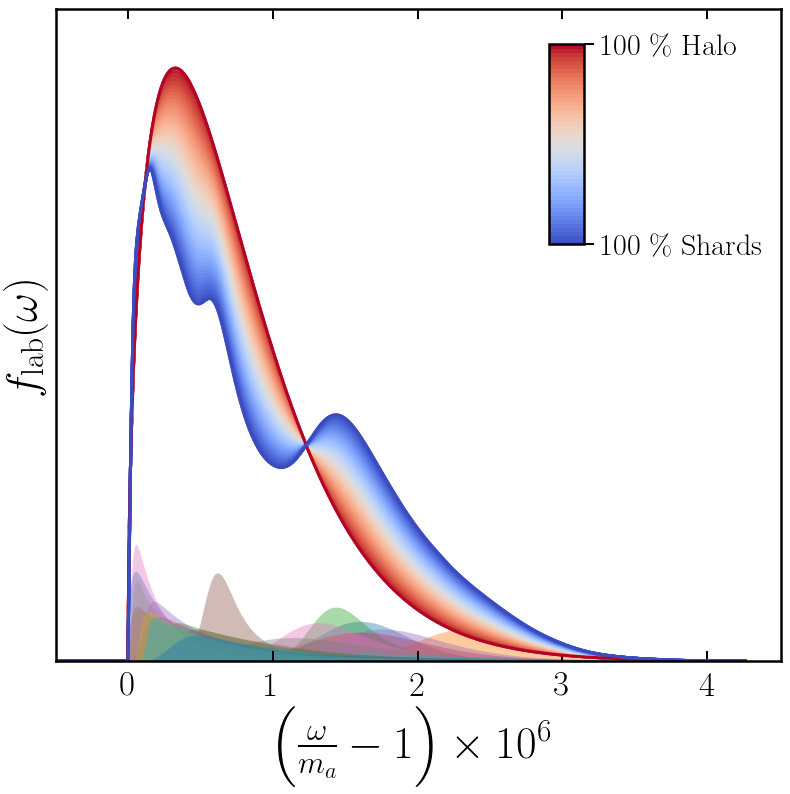

In [211]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_axionspectrum'

x = 1e6*(omega/m_a_s-1)
ys = domega*dv

for i in range(0,n_xi):
    plt.fill_between(x,ys*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv_Iso),y2=ys*sum(fv,0),color=col[i,:],alpha=0.5)
    plt.plot(x,ys*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv_Iso),'-',color=col[i,:],linewidth=3)
    
plt.plot(x,ys*fv_Iso,'-',color=col[0,:],linewidth=3,label=r'100 \% Halo')
plt.plot(x,ys*sum(fv,0),'-',color=col[-1,:],linewidth=3,label=r'100 \% Shards')

# Plot individual streams
for i in range(0,nshards):
    plt.fill_between(x,ys*fv[i,:],linewidth=3,alpha=0.4)
    
ax.set_xlim(left=-0.5)
ax.set_ylim(bottom=0.0,top=amax(fv_Iso*ys)*1.1)
ax.tick_params(which='major',direction='in',width=2,length=10,left=False,top=True,pad=10,labelleft=False)
plt.xticks(fontsize=35)
plt.xlabel(r"$\left(\frac{\omega}{m_a} -1\right)\times 10^6$",fontsize=45);
plt.ylabel(r"$f_{\rm lab}(\omega)$",fontsize=45);

# Custom colorbar
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-50, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([r'100 \% Shards', r'100 \% Halo'])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Directional signal

In [255]:
import warnings
warnings.filterwarnings("ignore", module="mpl_toolkits.basemap")
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(12,10))
pltname = 'Shards_Directional'

n = 200
ph = linspace(-pi, pi-2*pi/n, n)
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 20.0
sigma_p = 1.0e-45
A = F19.MassNumber

# Radon transform and rate
dR0 = zeros(shape=(3,n*n/2))
dR = zeros(shape=(3,n*n/2))
fhat0 = zeros(shape=(n*n/2))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,v_lab,v0,v_esc)
        dR0[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)

        fhat = zeros(shape=(n*n/2))
        for i in range(0,nshards):
            v_s = dat[i,0:3]
            sig_s = sqrt(sum(dat[i,6:9]**2.0))/3.0
            fhat += fhat_Isotropic(v_min[ie],-1.0*q,v_lab-v_s,sqrt(2.0)*sig_s,v_esc)/(1.0*nshards)
        dR[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print 'bin =',ibin

    

# Convert list into Mollweide map
dR_map0 = zeros(shape=(n/2,n,3))
dR_map = zeros(shape=(n/2,n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            dR_map0[i,j,ibin] = dR0[ibin,ii]
            dR_map[i,j,ibin] = dR[ibin,ii]
            ii = ii+1
    dR_map0[:,:,ibin] = flipud(dR_map0[:,:,ibin])     
    dR_map[:,:,ibin] = flipud(dR_map[:,:,ibin])        

bin = 0
bin = 1
bin = 2


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see

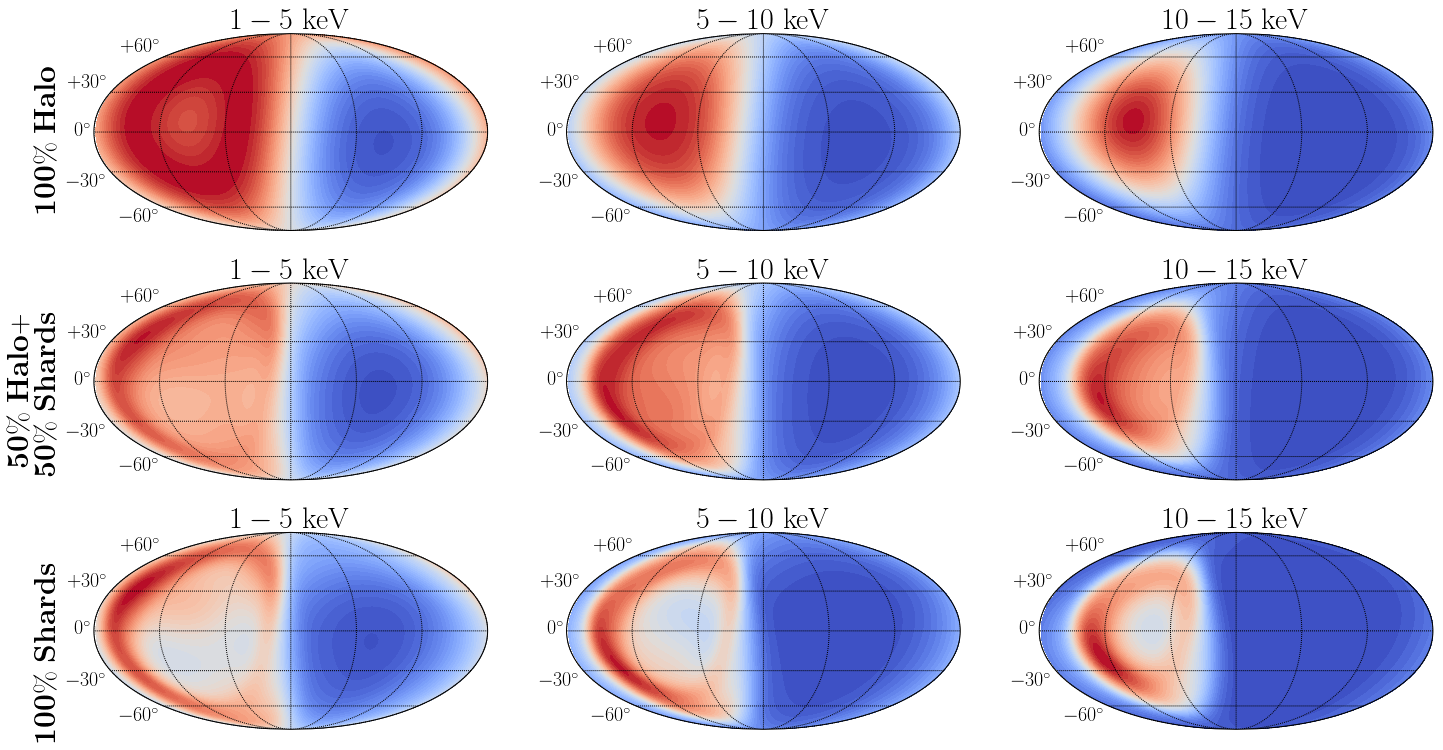

In [261]:
fig, axarr = plt.subplots(3, 3,figsize=(24,13))
warnings.filterwarnings("ignore")

tit = [r'$1 - 5$ keV',r'$5-10$ keV',r'$10-15$ keV']
for ibin in range(0,3): 
    plt.sca(axarr[0,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map0[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

for ibin in range(0,3): 
    plt.sca(axarr[1,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, 0.5*dR_map0[:,:,ibin]+0.5*dR_map[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

for ibin in range(0,3): 
    plt.sca(axarr[2,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

plt.sca(axarr[0,0])
plt.annotate(r'{\bf 100}\% {\bf Halo}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(axarr[1,0])
plt.annotate(r'{\bf 50}\% {\bf Halo}+', xy=(-0.22, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)
plt.annotate(r'{\bf 50}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(axarr[2,0])
plt.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

#plt.tight_layout()
# colorbar
#cbar = plt.colorbar(orientation='horizontal',pad=0.02)
#cbar.ax.tick_params(labelsize=20,pad=10)
#cbar.set_label(r'$\frac{{\rm d}^2 R}{{\rm d}E_r {\rm d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=35,labelpad=10)
plt.show()

# save figure
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')